In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime  import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error as mae
import io

energy_demand =pd.read_csv('/content/victoria state dataset.csv')
energy_demand.head()
energy_demand.shape
df=energy_demand.copy()
df['date']=pd.to_datetime(df['date'])
df.rainfall.fillna(df.rainfall.median(), inplace=True)

df.solar_exposure.fillna(df.solar_exposure.median(), inplace=True)
df.info()
df.isna().sum()
#To extract the year
df['Year'] = df['date'].dt.year
#To extract the month
df['Month'] = df['date'].dt.month
#To extract the day
df['Day'] = df['date'].dt.day


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2106 non-null   datetime64[ns]
 1   demand           2106 non-null   float64       
 2   RRP              2106 non-null   float64       
 3   demand_pos_RRP   2106 non-null   float64       
 4   RRP_positive     2106 non-null   float64       
 5   demand_neg_RRP   2106 non-null   float64       
 6   RRP_negative     2106 non-null   float64       
 7   frac_at_neg_RRP  2106 non-null   float64       
 8   min_temperature  2106 non-null   float64       
 9   max_temperature  2106 non-null   float64       
 10  solar_exposure   2106 non-null   float64       
 11  rainfall         2106 non-null   float64       
 12  school_day       2106 non-null   object        
 13  holiday          2106 non-null   object        
dtypes: datetime64[ns](1), float64(11), objec

In [ ]:
df_1=df.copy()

In [ ]:
norm_scale=MinMaxScaler()
df_scaled=norm_scale.fit_transform(df_1[['RRP','demand','demand_pos_RRP','RRP_positive', 'demand_neg_RRP', 'RRP_negative','min_temperature',
                                         'max_temperature', 'solar_exposure', 'rainfall']])
df_scaled=pd.DataFrame(df_scaled, columns=['RRP','demand','demand_pos_RRP','RRP_positive', 'demand_neg_RRP', 'RRP_negative','min_temperature',
                                         'max_temperature', 'solar_exposure', 'rainfall'])
df_scaled['date']=df_1['date']
df_scaled['holiday']=df_1['holiday']
df_scaled['school_day']=df_1['school_day']
df_scaled=pd.get_dummies(df_scaled)
df_scaled.shape
df_ready=df_scaled.dropna()
df_ready.date.shape
df_train = df_ready[df_ready.date<='2019-01-01']
#Test dataset
df_test =  df_ready[df_ready.date>'2019-01-01']
#A reserved copy of the test dataset for plotting
df_resid = df_ready[df_ready.date>'2019-01-01']

#Extract the target feature for training and testing
y_train=df_train["demand"]
y_test=df_test["demand"]

#Extracting the independent features for training and testing
X_train =df_train.drop(labels=['demand', 'date'], axis=1)
X_test=df_test.drop(labels=['demand', 'date'], axis=1)
df_train.shape
print(f'X_train:', len(X_train))
print(f'y_train:', len(y_train))
print(f'X_test:', len(X_test))
print(f'y_tets:', len(y_test))

X_train: 1462
y_train: 1462
X_test: 644
y_tets: 644


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

sequence_length=24

# Create time series generators for training and testing
train_data_gen = TimeseriesGenerator(X_train.values, y_train.values, length=sequence_length, batch_size=32)
test_data_gen = TimeseriesGenerator(X_test.values, y_test.values, length=sequence_length, batch_size=32)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GRU
from scipy.optimize import differential_evolution
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import time

def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = K.abs(error) < delta
    small_error_loss = 0.5 * K.square(error)
    large_error_loss = delta * (K.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

class MultiHeadAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.head_dim = key_dim // num_heads

        # Query, Key, and Value Projections
        self.query_projection = Dense(key_dim)
        self.key_projection = Dense(key_dim)
        self.value_projection = Dense(key_dim)

        # Scaled Dot-Product Attention
        self.attention = tf.keras.layers.Attention(use_scale=True)

        # Linear Transformation
        self.output_projection = Dense(key_dim)

    def call(self, inputs):
        # Split inputs into query, key, and value
        query = self.query_projection(inputs)
        key = self.key_projection(inputs)
        value = self.value_projection(inputs)

        # Split into multiple heads
        query_heads = tf.concat(tf.split(query, self.num_heads, axis=-1), axis=0)
        key_heads = tf.concat(tf.split(key, self.num_heads, axis=-1), axis=0)
        value_heads = tf.concat(tf.split(value, self.num_heads, axis=-1), axis=0)

        # Scaled Dot-Product Attention
        attention_output = self.attention([query_heads, key_heads, value_heads])

        # Concatenate heads
        attention_output = tf.concat(tf.split(attention_output, self.num_heads, axis=0), axis=-1)

        # Linear Transformation
        output = self.output_projection(attention_output)

        return output


class TabularLSTMGRUModel:
    def __init__(self, input_shape, lstm_units=[64, 32], gru_units=[64, 32], output_units=1, num_heads=8):
        self.input_shape = input_shape
        self.lstm_units = lstm_units
        self.gru_units = gru_units
        self.output_units = output_units
        self.num_heads = num_heads
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential()

        # Convolutional layers
        model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.BatchNormalization())

        model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.BatchNormalization())

        model.add(MultiHeadAttentionLayer(num_heads=self.num_heads, key_dim=self.lstm_units[-1]))

        model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.BatchNormalization())

        # Multi-Head Attention layer
        model.add(MultiHeadAttentionLayer(num_heads=self.num_heads, key_dim=self.lstm_units[-1]))

        # GRU layers
        for units in self.gru_units:
            model.add(GRU(units, return_sequences=True, activation='relu'))

        model.add(Flatten())
        model.add(Dense(self.output_units))

        return model

    def compile(self, learning_rate=0.001):
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(loss=huber_loss, optimizer=optimizer)

    def fit(self, train_data_gen, epochs=10):
        start_time = time.time()
        history = self.model.fit(train_data_gen, epochs=epochs)
        end_time = time.time()
        execution_time = end_time - start_time

        return history, execution_time

    def evaluate(self, test_data_gen):
        return self.model.evaluate(test_data_gen)

    def predict(self, data_gen):
        return self.model.predict(data_gen)

    def summary(self):
        return self.model.summary()

In [ ]:
# Assuming you have the input_shape and train_data_gen defined
input_shape = (24, 11)
lstm_units = [64, 32, 16, 8]
gru_units = [64, 32, 16, 8]  # Define the units for each GRU layer
lstm_gru_model = TabularLSTMGRUModel(input_shape, lstm_units=lstm_units, gru_units=gru_units)
num_epochs = 100
# Compile the model
lstm_gru_model.compile()
lstm_gru_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 23, 256)           5888      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 11, 256)           0         
 g1D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 11, 256)           1024      
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 128)           65664     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                      

In [ ]:
history, execution_time = lstm_gru_model.fit(train_data_gen, epochs=num_epochs)

Epoch 1/100
45/45 [==============================] - 14s 25ms/step - loss: 0.0631
Epoch 2/100
45/45 [==============================] - 1s 26ms/step - loss: 0.0180
Epoch 3/100
45/45 [==============================] - 1s 26ms/step - loss: 0.0132
Epoch 4/100
45/45 [==============================] - 1s 26ms/step - loss: 0.0119
Epoch 5/100
45/45 [==============================] - 1s 31ms/step - loss: 0.0113
Epoch 6/100
45/45 [==============================] - 2s 42ms/step - loss: 0.0111
Epoch 7/100
45/45 [==============================] - 1s 30ms/step - loss: 0.0113
Epoch 8/100
45/45 [==============================] - 1s 27ms/step - loss: 0.0105
Epoch 9/100
45/45 [==============================] - 1s 26ms/step - loss: 0.0095
Epoch 10/100
45/45 [==============================] - 1s 27ms/step - loss: 0.0083
Epoch 11/100
45/45 [==============================] - 1s 27ms/step - loss: 0.0083
Epoch 12/100
45/45 [==============================] - 1s 26ms/step - loss: 0.0079
Epoch 13/100
45/45 [====

In [ ]:
# Save the training loss values
training_loss_values = history.history['loss']

# Save training loss values to a file
np.savetxt('training_loss_values.csv', training_loss_values, delimiter=',')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error
import numpy as np

y_pred = lstm_gru_model.predict(test_data_gen)
y_true = y_test.values[:len(y_pred)].flatten()

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)
explained_variance = explained_variance_score(y_true, y_pred)
max_err = max_error(y_true, y_pred)

# Additional metrics for poisson and gamma distributions (you may need to replace these with your actual predictions)
poisson_deviance = np.mean(2 * (y_true * np.log(y_true / y_pred) - (y_true - y_pred)))
gamma_deviance = np.mean(2 * ((np.log(y_pred) - np.log(y_true)) + (y_true - y_pred) / y_pred))

# Print or use the calculated metrics as needed
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R2:", r2)
print("Explained Variance:", explained_variance)
print("Max Error:", max_err)
print("Mean Poisson Deviance:", poisson_deviance)
print("Mean Gamma Deviance:", gamma_deviance)


20/20 [==============================] - 2s 13ms/step
MAE: 0.16349029739722967
MSE: 0.04130063837722922
RMSE: 0.20322558494744017
MAPE: 63.82929599114334
R2: -0.6156699255410933
Explained Variance: -0.6154459443130422
Max Error: 0.6190963531223995
Mean Poisson Deviance: 0.15601194879202893
Mean Gamma Deviance: 0.5370460686839229


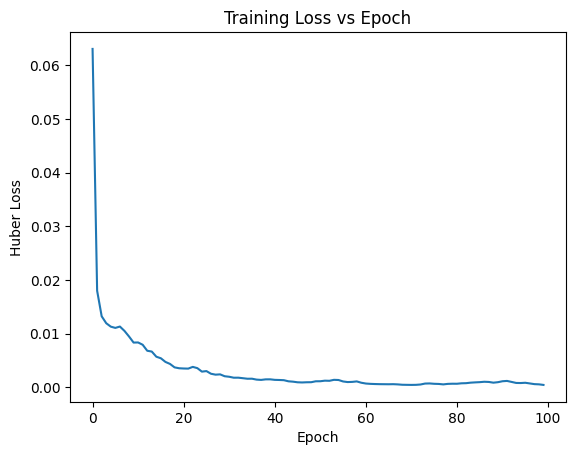

20/20 [==============================] - 0s 13ms/step


In [ ]:
# Plotting training loss vs epoch
plt.plot(training_loss_values)
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.show()

# Save only the test predictions in a CSV file
test_predictions = lstm_gru_model.predict(test_data_gen)

# Save test predictions to a CSV file
np.savetxt('test_predictions.csv', test_predictions, delimiter=',')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error
import numpy as np

y_pred = lstm_gru_model.predict(test_data_gen)
y_true = y_test.values[:len(y_pred)].flatten()

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)
explained_variance = explained_variance_score(y_true, y_pred)
max_err = max_error(y_true, y_pred)

# Additional metrics for poisson and gamma distributions (you may need to replace these with your actual predictions)
poisson_deviance = np.mean(2 * (y_true * np.log(y_true / y_pred) - (y_true - y_pred)))
gamma_deviance = np.mean(2 * ((np.log(y_pred) - np.log(y_true)) + (y_true - y_pred) / y_pred))

# Print or use the calculated metrics as needed
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R2:", r2)
print("Explained Variance:", explained_variance)
print("Max Error:", max_err)
print("Mean Poisson Deviance:", poisson_deviance)
print("Mean Gamma Deviance:", gamma_deviance)


In [ ]:
# Plotting training loss vs epoch
plt.plot(training_loss_values)
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.show()

# Save only the test predictions in a CSV file
test_predictions = lstm_gru_model.predict(test_data_gen)

# Save test predictions to a CSV file
np.savetxt('test_predictions.csv', test_predictions, delimiter=',')

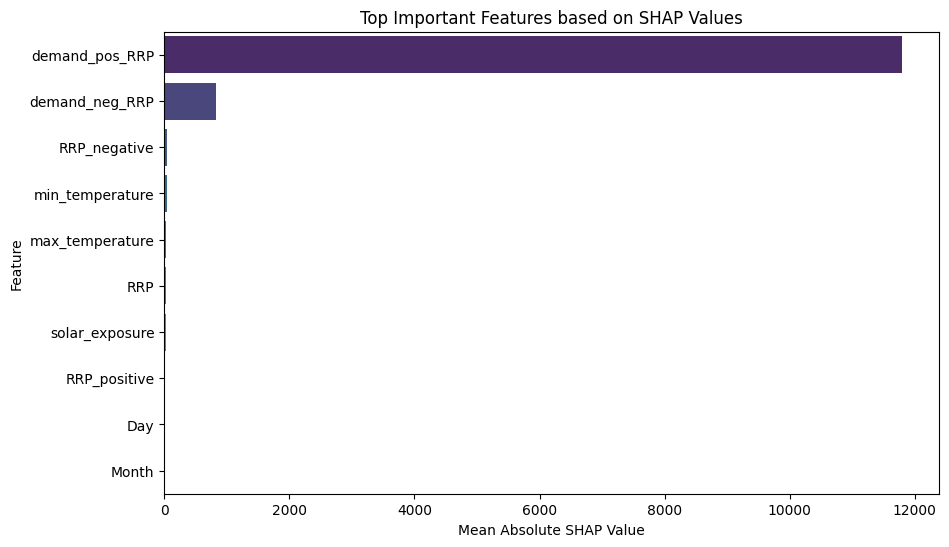

In [ ]:
# Get the mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame(list(zip(X.columns, mean_abs_shap_values)),
                                     columns=['Feature', 'Mean Absolute SHAP Value'])

# Sort the DataFrame by mean absolute SHAP value in descending order
feature_importance_df = feature_importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Display the top N important features (adjust N as needed)
top_n_features = 10
top_features = feature_importance_df.head(top_n_features)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Mean Absolute SHAP Value', y='Feature', data=top_features, palette='viridis')
plt.title(f'Top Important Features based on SHAP Values')
plt.show()
